# Introduction

The Digital Africa Plantation Counting Challenge is a challenge that was hosted by Zindi (a community of African Data Scientists hosting a wide range of machine learning challenges) and Digital Africa (https://digital-africa.co/). The subject of the challenge was to count the number of palm oil tree in drone images collected from farms in Côte d'Ivoire. This project uses the provided dataset as an example to show how to create a simple baseline model to count instances of a particular object within an image. Further details about the competition can be found here: https://zindi.africa/competitions/digital-africa-plantation-counting-challenge. 

This project uses the challenge and its data to first create a simple baseline counting model using a popular pretrained backbone and later try to improve on this baseline by introducing a second model that is trained to boost the initial predictions while using a different resolution scale from the first model.



# Preparations of Code and Data

As the dataset is property of the competition hosts and publication is not permitted, the project does not contain any actual images nor metadata of the images. The trained models contain a large number of weights and are memory consuming (~50 MB each). Due to this reason the models have not been uploaded to this GitHub page. However, by visiting the competition's homepage and accepting the terms, private access to the dataset can still be gained and the code of this repository can be used to recreate the models and results. 

To do so, the folder structure of this repository must be copied and the images saved in './data/TreeImages', the (empty) file './data/TreeImages.csv' must be replaced by the real training csv file. The script 'simple_boosting.py' can then be run to create baseline and boosted models for different training and validation splits. To recreate the results presented here all random seeds in 'simple_boosting.py' must stay the same and the script must be run five times setting the variable 'fold' to 0 to 4 respectively. 

The following code snipet sets up the data and packages for analysis after the models have been trained. A short analysis is done within this Readme file next to some further explanation on the models and their code.  


In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sbn
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt
import albumentations as alb
import cv2

'''
Define the project path and get list of train
'''

PROJECT_PATH = '...'  # Set your path to the project directory here 
IMAGE_PATH = PROJECT_PATH + '/data/TreeImages/' 

os.chdir(PROJECT_PATH)
from help_funcs import base_model, f_base_model_prediction

train_csv = pd.read_csv(PROJECT_PATH + '/data/Train.csv') 

image_ids = np.array(train_csv.ImageId)
targets = np.array(train_csv.Target)


# Baseline Model

In this project a EfficientNet B3 backbone is used for the baseline model. The original family of EfficientNet network architecture was introduced in [1]. The EfficientNet architecture exists in different sizes - B0 to B7 - and a medium sized version (B3) was chosen to create the backbone. Torchvision provides an implementation of the EfficientNet B3 model along with pretrained weights that will be finetuned during training.

After downsampling the input images to a more managable input size (from 1024x1024 to 224x224) the backbone outputs a 1536-dimensional 7x7 feature map. In order to convert this feature map into a scalar prediction for the number of palm oil trees in an image we apply a global average pooling layer and afterwards a simple linear layer to combine the 1536 features into one single prediction. Note that we do not apply any further non-linearity after the backbone. More complex models with additional layers of fully connected networks after the backbone are certainly viable, however no significant advantage in comparison to the purely linear approach presented here was found.

The following two figures illustrate the full backbone structure and the complete base model we are using.




<figure>
    <img src="Figures/EffnetB3_illustration.png" width = "500" height="750">
     <p style='text-align: center'>
      <figurecaption>Figure 1: Full structure of the EfficientNet B3 network. IRC refers to inverted residual connection as introduced in [2]. The distinction between part 1 and part 2 of the network (part 2 beginning with the downscaling from 14x14 to 7x7) is important for the structure of the boosting model (see below). The figure has been taken from [3] and slightly altered to show the features output by the backbone and to highlight the distinction between what we call here part 1 and part 2 of the network.</figurecaption>
    </p>
</figure>

<figure>
    <img src="Figures/Base_Model.png" width = "750" height="300">
     <p style='text-align: center'>
      <figurecaption>Figure 2: After using the backbone to produce the feature map for each image, global average pooling and a simple linear layer are used to create the final output of our base model.</figurecaption>
    </p>
</figure>

As we can rely on the torchvision EfficientNet B3 backbone the code to create our base model becomes fairly simply (cdoe taken from help_funcs.py):

In [2]:
import torch
import torchvision.models as tv_models
class base_model (torch.nn.Module):
    '''
    Base model to count the plants within an image, using a
    pretrained EfficientNet B3 backbone.
    '''
    def __init__(self):
        '''
        Architecture of model:
            Image -> Backbone -> Pooling -> Linear Layer -> Scalar output (estimated count) 
        '''
        super(base_model, self).__init__()
        
        self.backbone = tv_models.efficientnet_b3(weights = 'EfficientNet_B3_Weights.DEFAULT')
        self.n_features = 1536 
        self.pooling_layer = torch.nn.AdaptiveAvgPool2d((1,1))
        self.final_layer = torch.nn.Linear(self.n_features, 1)
    
    
    def forward(self, image):
        '''
        Forward method to output an estimated plant count for each input image.
        Input:
            image (torch.tensor): image tensor of size (*,3,img_size, img_size)
        Output:
            torch.tensor of size (*) representing the estimated count of plants
            within each image of the input.
        '''
        x = self.backbone.features(image)
        x = self.pooling_layer(x).squeeze()
        x = self.final_layer(x)
            
        return x

# Baseline Model Performance

Using the above defined baseline model a 5-fold cross validation was performed, resulting in 5 baseline models and 5 corresponding RMSE (root mean squared error) scores on the respective validation set. The code to create these 5 models and their scores is shown in simple_boosting.py. As explained earlier the models have not been uploaded to this GitHub page, but the code is set up to reproduce the models via training once the images are stored in the right folder (see 'Preparations of Code and Data' for further instructions on reproducing the models and results).

We will have a look at the performance of base_model_0 (that is the first of the 5 cross validated baseline models). Let's check first on the target distribution of the corresponding validation set.

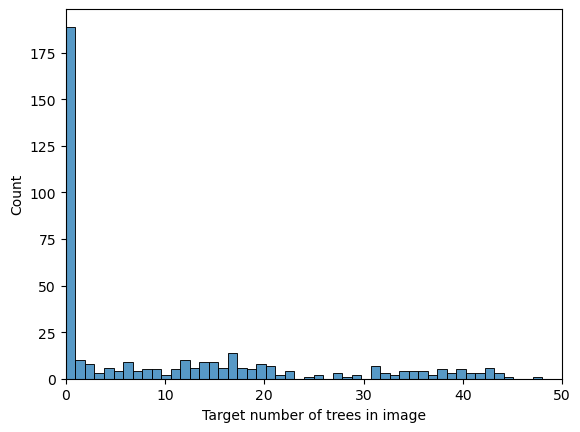

Mean number of trees in image =  10.256857855361597
Naive prediction RMSE =  13.429834621370103


In [3]:
### Define the fold that should be run 
no_folds = 5
fold = 0

split_seed = 13579                  # here we need to define the same splitting seed, test_size, img_size etc. as in simple_boosting.py
test_size = 1/no_folds
img_size = 224
batch_size = 8
model_device = torch.device('cuda') # chosse pytorch device, set 'cpu' if not 'cuda'-compatible 

### Replicate the train-valid-split of the training procedure
splitter_state = np.random.RandomState(split_seed)
KFold_splitter = KFold(n_splits = no_folds, shuffle = True, random_state = splitter_state)
idxs_train, idxs_valid = list(KFold_splitter.split(image_ids))[fold]

## Get validation target distribution

targets_valid = targets[idxs_valid]

fig, ax = plt.subplots()
sbn.histplot(targets_valid, bins = 50, ax=ax)  # distplot is deprecate and replaced by histplot
ax.set_xlim(0,50)
ax.set_xlabel('Target number of trees in image')
#ax.set_xticks(range(1,32))
plt.show()
print("Mean number of trees in image = ", targets[idxs_valid].mean())
print("Naive prediction RMSE = ", np.sqrt(((targets_valid - targets_valid.mean())**2).mean()))

We can see that there are a lot of images without trees (about half of the images). Other than that there is a wide spread of images with different numbers of trees in it up to over 40 trees per image. On average we have 10 trees per image and a naive prediction of the mean for each image would result in a RMSE of about 13.5. 

Now, let's predict the tree count using our baseline model and check on the RMSE and R²-coefficient of these predictions.

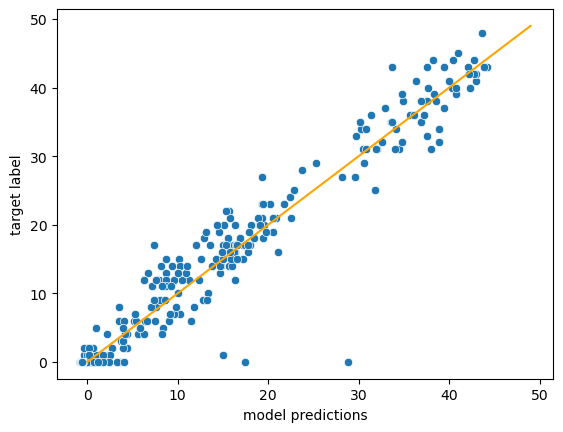

Validation RMSE of Model:  2.887490958027169
R^2 of predictions:  0.9537725501081827


In [4]:
### First load the models state_dict:
model_0 = base_model().to(model_device)
model_0.load_state_dict(torch.load(PROJECT_PATH + '/models_boosting/base_' + str(fold) + '.pth')['model_state_dict'])
model_0.eval()

### Remember to downsample the image to the needed 224x224 input size
downsampler = alb.Resize(img_size, img_size, interpolation = cv2.INTER_LINEAR)

### Make predictions; for details of f_base_model_prediction see help_funcs.py
model_0_preds = f_base_model_prediction (model_0, batch_size, image_ids[idxs_valid], downsampler, None, img_size,
                             model_device, IMAGE_PATH)

fig, ax = plt.subplots()
sbn.scatterplot(x = model_0_preds, y = targets_valid)
sbn.lineplot(x = np.arange(50), y = np.arange(50), color = 'orange')
ax.set_xlabel('model predictions')
ax.set_ylabel('target label')
plt.show()

print("Validation RMSE of Model: ", np.sqrt(((targets_valid - model_0_preds)**2).mean()))
print("R^2 of predictions: ", 1 - ((targets_valid - model_0_preds)**2).sum() / ((targets_valid - targets_valid.mean())**2).sum())


With a RMSE of around 2.9 the base model works already very well! The R² coefficient implies that we can explain 95% of variation in the target variable with our predictions. The scatterplot shows that there are a few outliers for which our model predicts quite a few trees (more than 15, in one case even almost 30) while the images are labeld with zero or almost zero trees. When checking some of the images by hand these examples seem to be labeled wrongly and in fact our model is correct when predicting several trees in them. Taking these large outliers into account the actual RMSE and R² are probably even a little bit better.

# Boosting the Baseline

We will now present a way of boosting the prediction of our baseline model in order to (slightly) improve the cross validation RMSE. The basic idea of boosting is well known in Machine Learning and can be summarized as follows:

1) Train a model M1 that outputs predictions $\hat{y}_1$ for the targets $y$.
2) Calculate the difference between actual targets and predictions $y - \hat{y}_1$.
3) Train a second Model M2. But instead of using $y$ as a target, train the model to predict the prediction error $y - \hat{y}_1$.
4) The joint prediction of M1 and M2 will be $\hat{y}_1 + \hat{y}_2$. In other words we boost the the prediction $\hat{y}_1$ by our second Model M2 that was trained to 'correct' some of the prediction erros made by Model M1.

The prime example for boosting are boosted decision trees like the ones used in XGBoost or Catboost, where the boosting process is usually repeated hundreds of times using many simple models to create a joint prediction. However, we will use only one boosting iteration - keeping in mind that our model is already working very well and much more complex and computationally expensive than a single decision tree. 

And we will differ from the usual boosting process in another important way: Usually the base model M1 and the boosting model M2 are of the same type with the same hyperparameters (or in terms of neural networks: They have the same architecture). But here we will slightly change the structure of M2. In particular we will use a different resolution scale of the image to predict the targets, that is we will not base our predictions on a 7x7 feature map generated by the backbone but on a 14x14 feature map. 

The idea of using different scales of the image to produce better predictions is commonly used in computer vision. In particular the model used in this project has been inspired by [4]. In [4] the authors use a structure very similar to what has been done in this project, however instead of boosting the baseline prediction of the highest resolution output by lower resolution outputs, the authors create a Multiple-Scale Regression that uses a weighted mean of the various resolution-specific outputs instead. We found in our particular case the boosting to be working better than a weighted mean. 

The architecture of the boosting model is illustrated below. Note that once more we do not add any new non-linearities but stayed with the most simple set up of only putting tensors together linearly. Again this is mainly due to the lack of performance gain we observed when adding non-linearities. 

<figure>
    <img src="Figures/Boosting_Model.png" width = "1000" height="450">
     <p style='text-align: center'>
      <figurecaption>Figure 3: In the boosting model architecture features are temporarily saved after part 1 of the backbone and added to the final feature map after an upscaling and linear channel reduction. This way we get a lower resoluation feature map (14x14) that still contains information from the highest resolution (7x7 after running through the whole backbone) - see also [4] where a similar architecture was used. For the exact distinction between part 1 and part 2 of the backbone network see Figure 1. </figurecaption>
    </p>
</figure>

Again, making use of the pretrained EfficientNet B3 provided by torchvision, an implementation of this model is actually fairly simple:

In [5]:
class boost_model (torch.nn.Module):
    
    '''
    Upsampling model used to boost the prediction of a base_model instance.
    Again we use a pretrained a EfficientNet B3 backbone.
    '''
    
    def __init__(self):
        
        '''
        Architecture of model
            (I) image -> backbone part 1 -> (save features feats) 
                      -> backbone part 2 -> Upsample (factor x2) -> x
            (II) (merge x and feats) -> merged x
            (III) merged x -> Pooling -> Linear Layer -> Scalar output 
        
        '''
        super(boost_model, self).__init__()
        
        self.backbone = tv_models.efficientnet_b3(weights = 'EfficientNet_B3_Weights.DEFAULT')
        
        self.channel_reduction = torch.nn.Conv2d(1536,256,1)
        self.upsample = torch.nn.Upsample(scale_factor = 2, mode = 'bilinear')
        
        self.channel_merge = torch.nn.Conv2d(136,256,1)
        self.reg_gap = torch.nn.AdaptiveAvgPool2d((1,1))
        self.single_linear = torch.nn.Linear(256,1)
        
    def forward(self, image):
        '''
        Forward method to output an estimated boost for the count of each input image.
        Input:
            image (torch.tensor): image tensor of size (*,3,img_size, img_size)
        Output:
            torch.tensor of size (*) representing the estimated boost for the 
            count of plants within each image of the input.
        '''
        x = image
        for i in range(9):
            x = self.backbone.features[i](x) # The features of resolution 14x14 are saved
            if i == 5:
                features = x
        
        # After running through the backbone, the 7x7 feature map is linearly upsampled
        # to match a 14x14 resolution
        x = self.upsample(self.channel_reduction(x)) 
        
        # The saved features and the upsampled backbone-output are merged,
        # pooled and run through a final linear layer to generate the scalar output.
        x = self.channel_merge(features) + x
        x = self.single_linear(self.reg_gap(x).squeeze())
        
        return x 

# Performance of the Boosted Model

On the basis of the five models that were created during the 5-fold cross validation for the baseline model, 5 boosting models on the same train-validation splits for the corresponding baseline models were created and the RMSE on the validation splits were calculated. The following graph shows the best RMSE documented during training for the base and boosted model on each of the 5 splits.

Mean RMSE of base models:	 2.6064 ± 0.3778 
Mean RMSE of boosted models:	 2.5121 ± 0.364


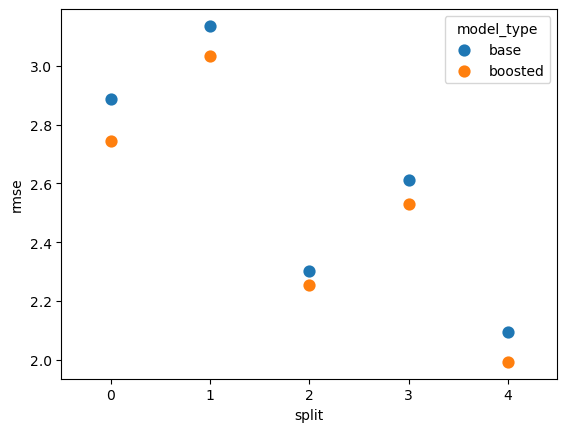

In [6]:
base_rmse = np.ones(5)
boosted_rmse = np.ones(5)

for i in range(5):

    base_rmse[i] = torch.load(PROJECT_PATH + '/models_boosting/base_' + str(i) + '.pth')['valid_rmse']
    boosted_rmse[i] = torch.load(PROJECT_PATH + '/models_boosting/boost_' + str(i) + '.pth')['valid_rmse']

plot_df = pd.DataFrame( {'split': np.tile(np.arange(5),2),
                         'rmse': np.concatenate((base_rmse, boosted_rmse)),
                         'model_type': np.concatenate((np.repeat('base',5), np.repeat('boosted',5)))})

sbn.pointplot(plot_df, x = 'split', y = 'rmse', hue = 'model_type', linestyles = '')

print("Mean RMSE of base models:\t", np.round(base_rmse.mean(),4), "\u00B1", np.round(base_rmse.std(), 4), 
      "\nMean RMSE of boosted models:\t", np.round(boosted_rmse.mean(),4), "\u00B1", np.round(boosted_rmse.std(), 4))


Indeed the improvement - albeit small - of the baseline model through boosting is consistent across all validation splits.

# References

[1] Mingxing Tan, Quoc V. Le: EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks; 2019.

[2] Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, Liang-Chieh Chen: MobileNetV2: Inverted Residuals and Linear Bottlenecks; 2018.

[3] Haikel Alhichri, Asma Alsuwayed, Yakoub Bazi, Nassim Ammour, Naif A. Alajlan: Classification of Remote Sensing Images using
EfficientNet-B3 CNN Model with Attention; 2021.

[4] Guy Farjon, Yotam Itzhaky, Faina Khoroshevsky, Aharon Bar-Hillel: Leaf Counting: Fusing Network Components for Improved Accuracy; 2021.